## Monitoring Results
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu
from smart_open import open
import pickle as pkl

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load config and set local variables with config["mconfig"]
with open("../../config.json", "r") as f:
    config = json.load(f)
    
mconfig = config["monitoring_config"]
locals().update(mconfig)   # this would set k-v pairs in mconfig as local variables
print(mconfig.keys())

dict_keys(['mmonth', 'dev_df_path', 'monitoring_dates', 'prod_data_dates', 'data_output_path', 'artifact_path', 'date_sample_start', 'date_sample_end', 'model_paths', 'prev_test_df_path', 'modeling_df_path', 'test_df_path', 'prod_dfs_path'])


In [3]:
# artifacts path
os.makedirs(artifact_path, exist_ok=True)

test_dfs = OrderedDict()

In [4]:
# read data
df = pd.read_parquet(test_df_path)

In [10]:
models = {}
for mname, mpath in model_paths.items():
    with open(mpath, "rb") as f:
        models[mname] = pkl.load(f)

### Active Accounts

  0%|          | 0/6 [00:00<?, ?it/s]

2021-10-01 (106276, 98)
data imbalance:  22.397471022128556
2021-10-01 (106276, 98)
data imbalance:  22.397471022128556


 17%|█▋        | 1/6 [00:13<01:05, 13.08s/it]

2021-11-01 (109267, 98)
data imbalance:  21.749004777070063
2021-11-01 (109267, 98)
data imbalance:  21.749004777070063


 33%|███▎      | 2/6 [00:26<00:53, 13.26s/it]

2021-12-01 (133802, 98)
data imbalance:  23.829385574354408
2021-12-01 (133802, 98)
data imbalance:  23.829385574354408


 50%|█████     | 3/6 [00:42<00:43, 14.35s/it]

2022-01-01 (125091, 98)
data imbalance:  23.182171979243883
2022-01-01 (125091, 98)
data imbalance:  23.182171979243883


 67%|██████▋   | 4/6 [00:57<00:29, 14.91s/it]

2022-02-01 (118822, 98)
data imbalance:  27.447909447909446
2022-02-01 (118822, 98)
data imbalance:  27.447909447909446


 83%|████████▎ | 5/6 [01:13<00:15, 15.01s/it]

2022-03-01 (125265, 98)
data imbalance:  46.32581360946745
2022-03-01 (125265, 98)
data imbalance:  46.32581360946745


100%|██████████| 6/6 [01:28<00:00, 14.81s/it]


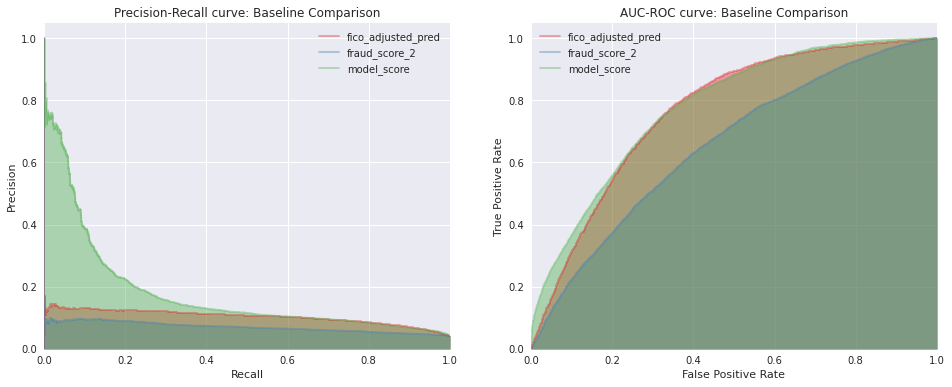

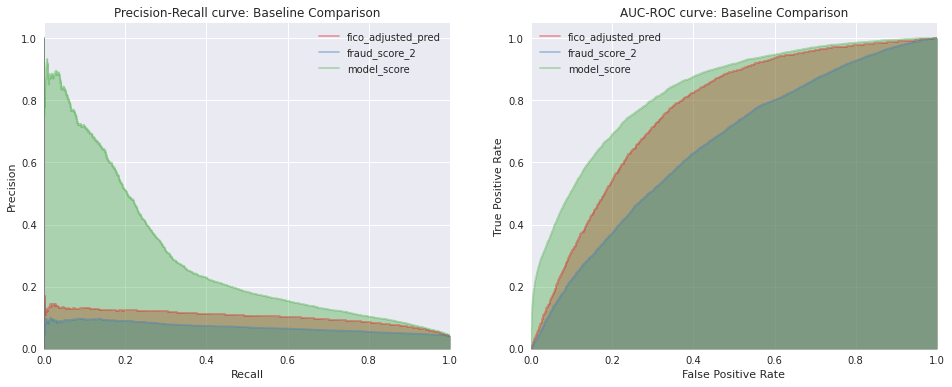

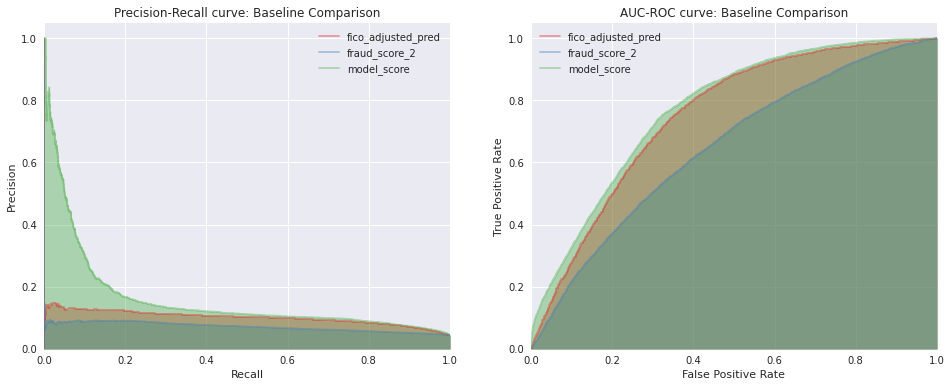

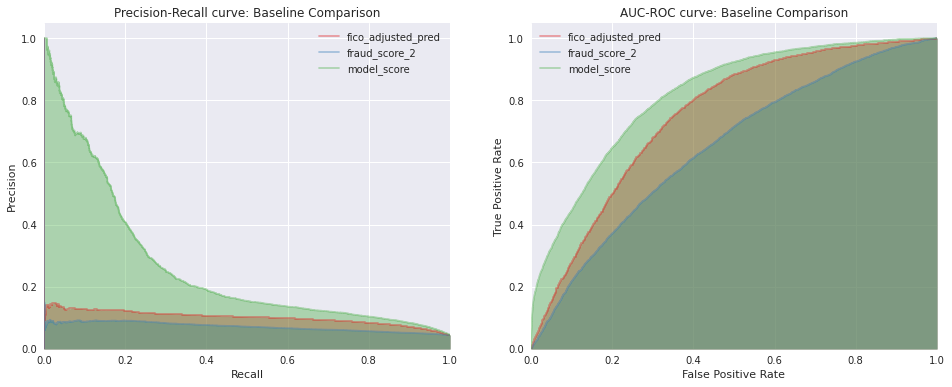

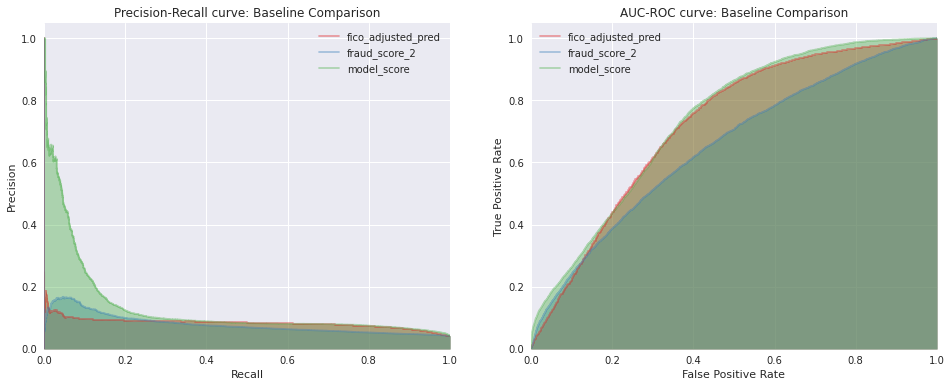

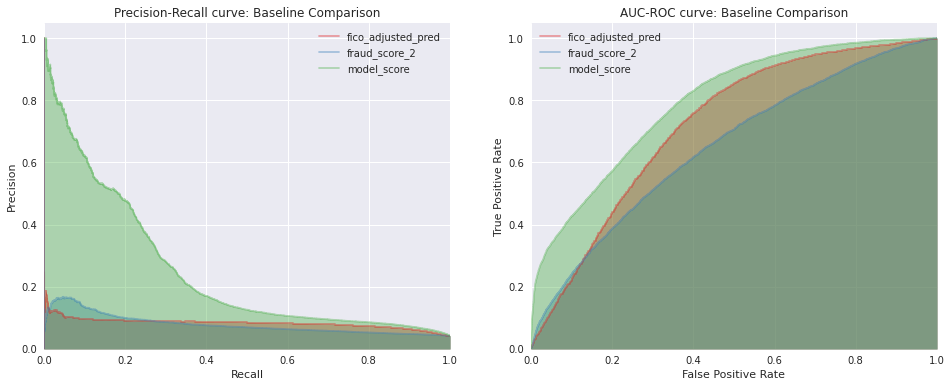

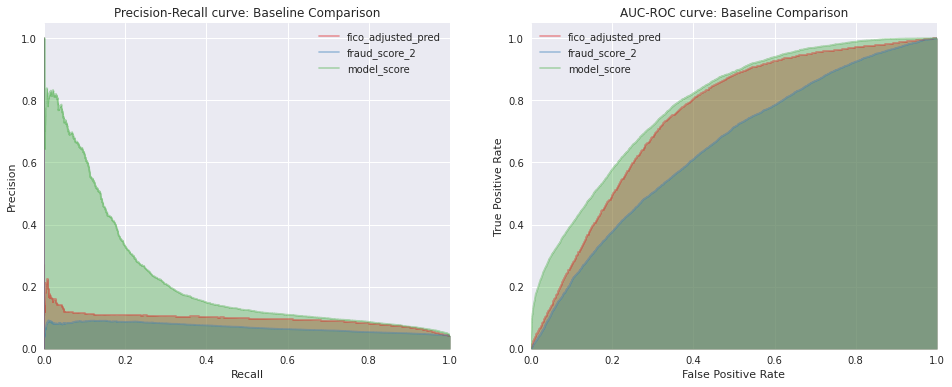

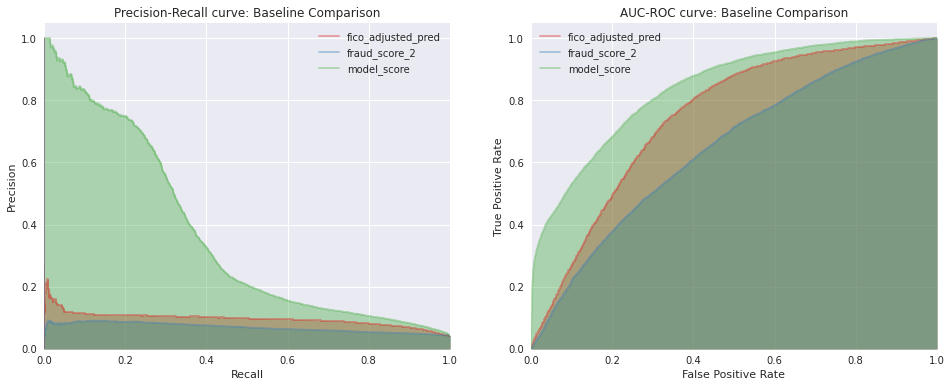

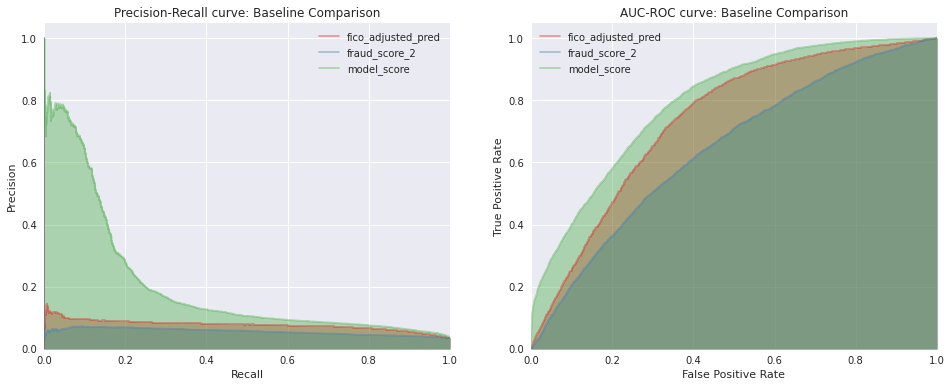

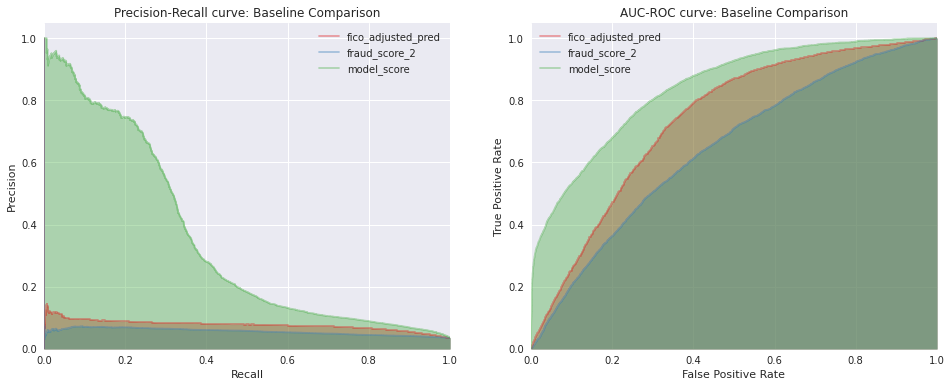

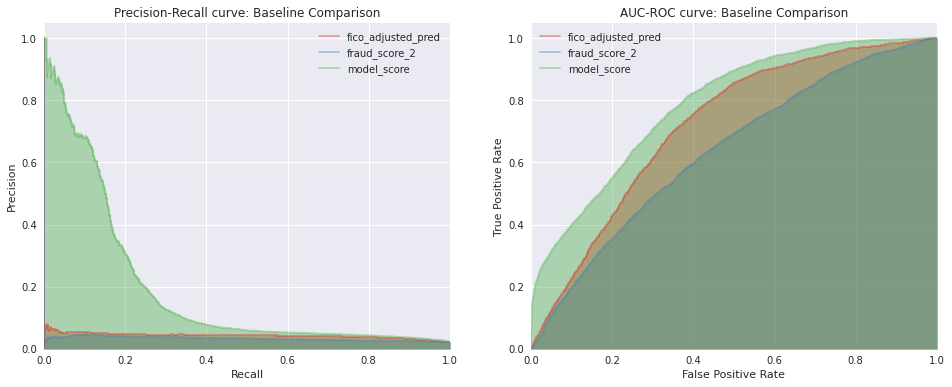

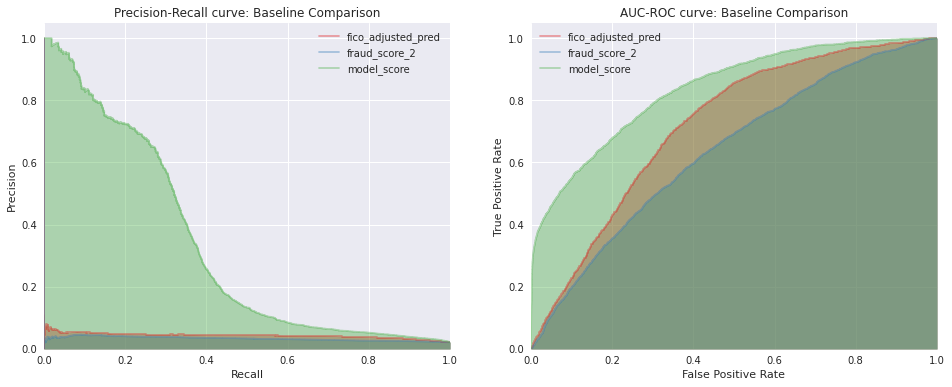

In [13]:
# get all the snapshots
for dt_str in tqdm(monitoring_dates):
    for mname, model in models.items(): 

        dt = pd.to_datetime(dt_str)

        # set folder:
        mntr_path = os.path.join(artifact_path, "monitoring", f"{mname}_{dt_str}_active")
        os.makedirs(mntr_path, exist_ok=True)
        
        # get data on that date
        df_ = df[df.is_static 
                 & (df.sample_date == dt)]
        
        # should have been processed when loaded, if not uncomment
        df_ = mu.prep_customer_data(df_)  # add is_active flag here
        df_ = df_[df_.is_active]
        print(dt_str, df_.shape)

        # see data imbalance
        print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])


        # make model pred and score
        df_["model_pred"] = model.predict_proba(df_[model.feature_name_])[:,1]
        df_["model_score"] = mu.scale_scores(df_["model_pred"])

        # insert into records
        test_dfs[dt_str] = df_
        pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
        report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)

        # store report in monitoring
        report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

        # model prediction
        mntr.get_segmented_performances(
            {dt_str: df_},
            "target",
            ["model_score"],
            mntr_path,
            model_name="customer_risk",
        )

        # on vs fico adjusted - only valid fico
        mntr.get_model_vs_baseline(
            df_[df_.fico_score.between(300,850)],
            "target",
            "model_score",
            "fico_adjusted_pred",
            mntr_path,
        )

        # auc/pr plots - on valid fico and sigma score
        plot_df = df_  # bad style
        plot_df = plot_df[
            ~plot_df[pred_cols].isna().any(axis=1) 
            & plot_df["fico_score"].between(300, 850)
        ]
        mntr.save_valid_performance_plots(
            {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
        )

### Full Population
---

  0%|          | 0/6 [00:00<?, ?it/s]

2021-10-01 (1083080, 91)
data imbalance:  121.7627880831928
2021-10-01 (1083080, 91)
data imbalance:  121.7627880831928


 17%|█▋        | 1/6 [01:42<08:32, 102.49s/it]

2021-11-01 (1147733, 91)
data imbalance:  121.72372467918126
2021-11-01 (1147733, 91)
data imbalance:  121.72372467918126


 33%|███▎      | 2/6 [03:30<07:03, 105.78s/it]

2021-12-01 (1269739, 91)
data imbalance:  120.7779891562827
2021-12-01 (1269739, 91)
data imbalance:  120.7779891562827


 50%|█████     | 3/6 [05:33<05:40, 113.66s/it]

2022-01-01 (1327105, 91)
data imbalance:  134.97813262815296
2022-01-01 (1327105, 91)
data imbalance:  134.97813262815296


 67%|██████▋   | 4/6 [07:42<03:58, 119.50s/it]

2022-02-01 (1367447, 91)
data imbalance:  160.12259953161592
2022-02-01 (1367447, 91)
data imbalance:  160.12259953161592


 83%|████████▎ | 5/6 [09:52<02:03, 123.41s/it]

2022-03-01 (1401616, 91)
data imbalance:  231.59550561797752
2022-03-01 (1401616, 91)
data imbalance:  231.59550561797752


100%|██████████| 6/6 [12:05<00:00, 120.96s/it]


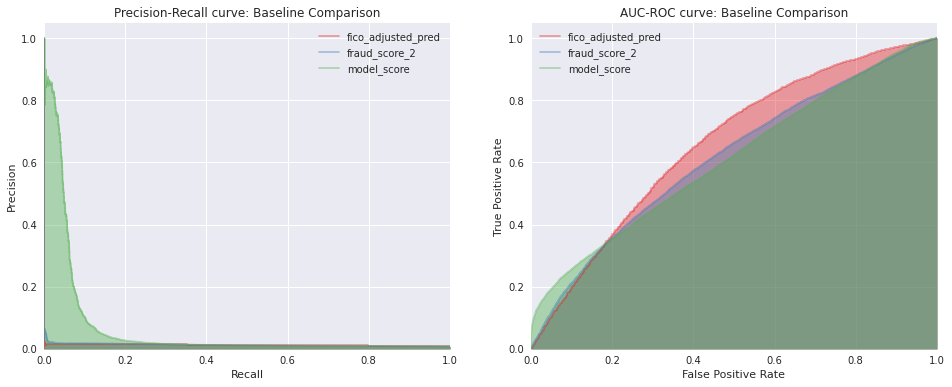

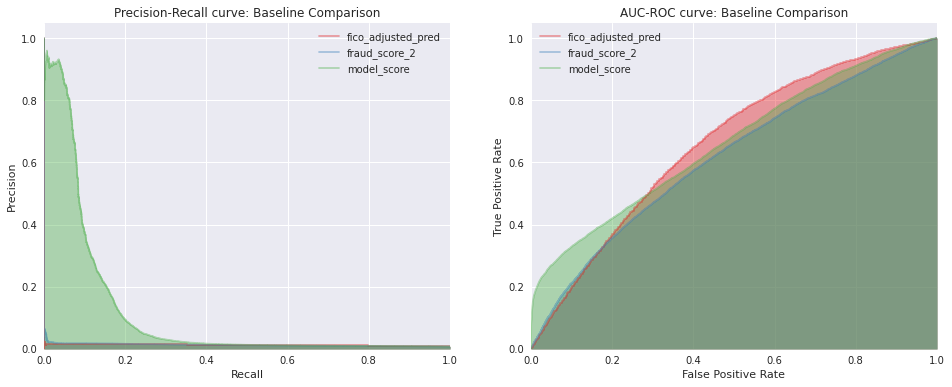

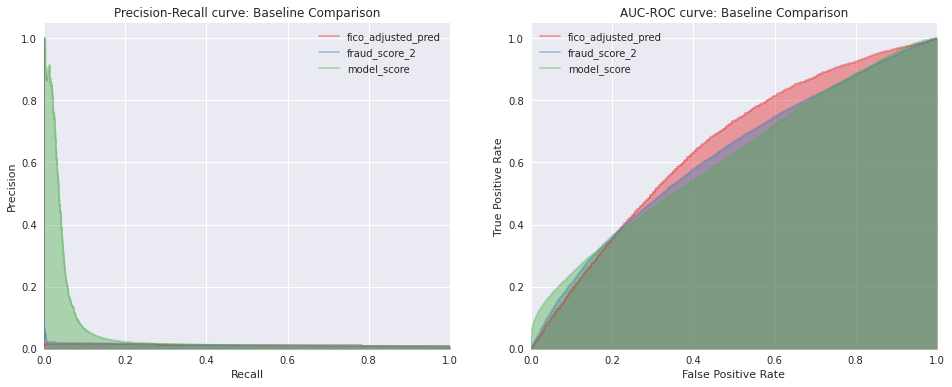

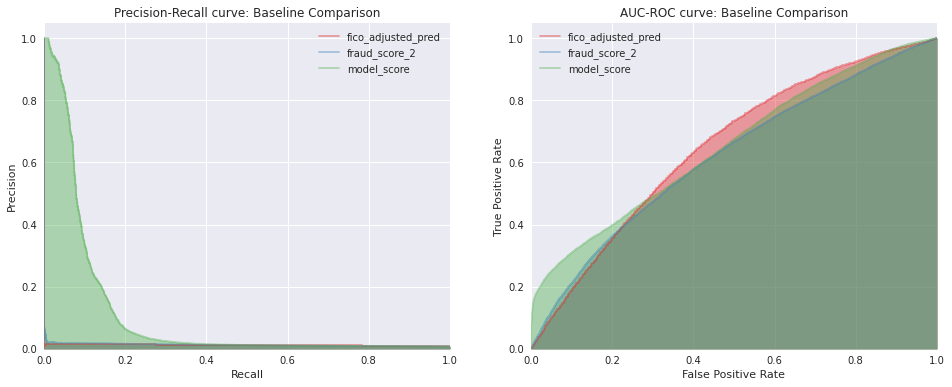

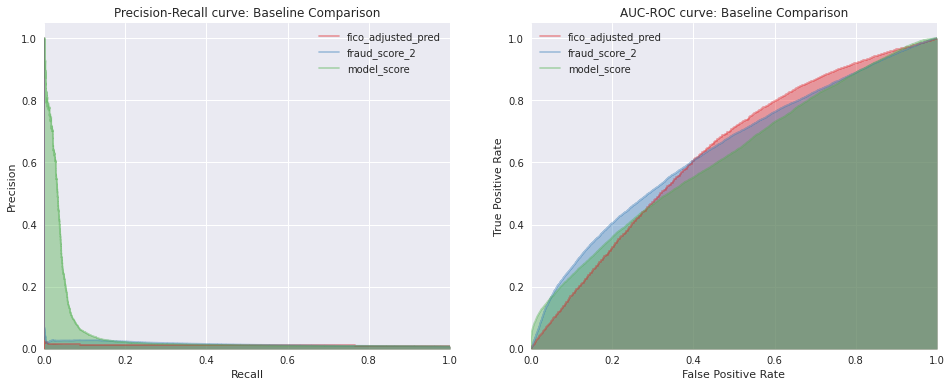

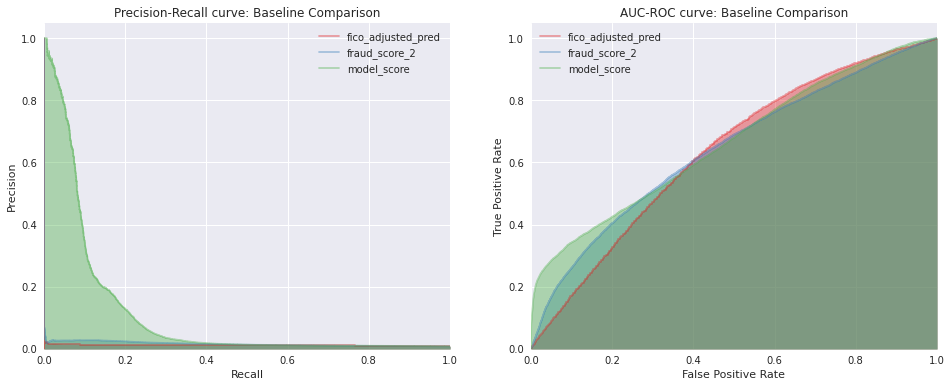

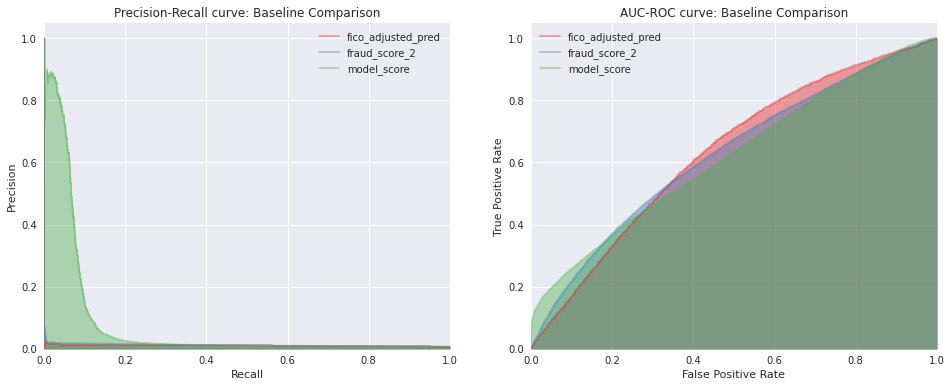

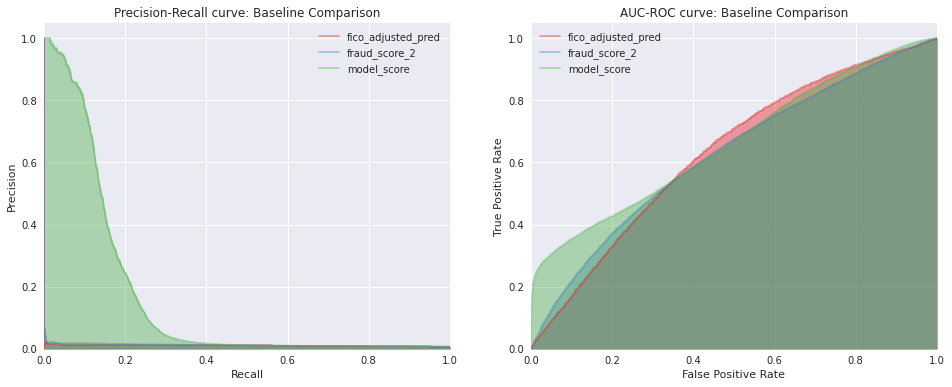

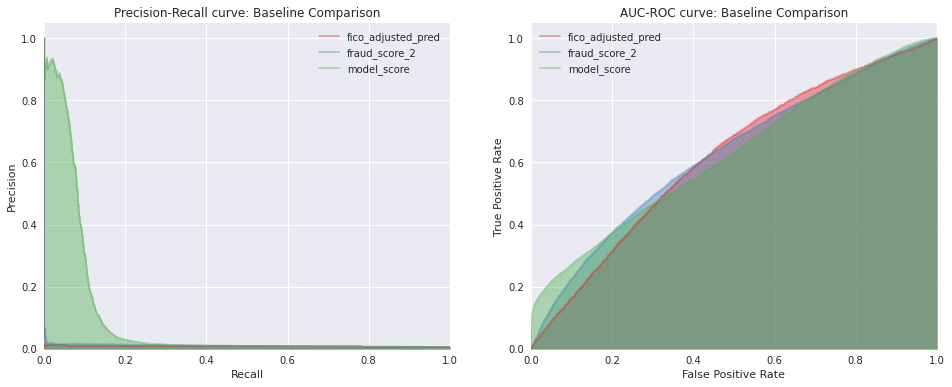

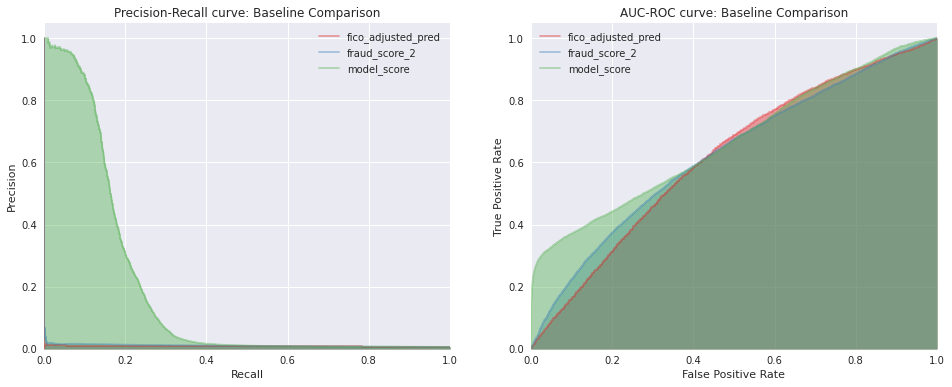

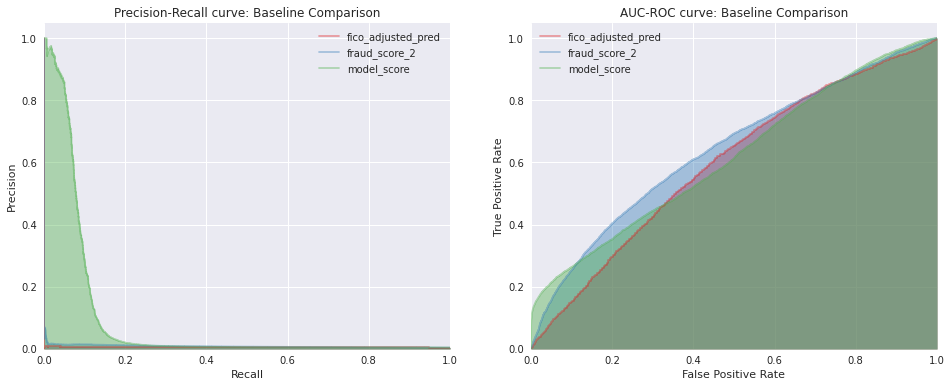

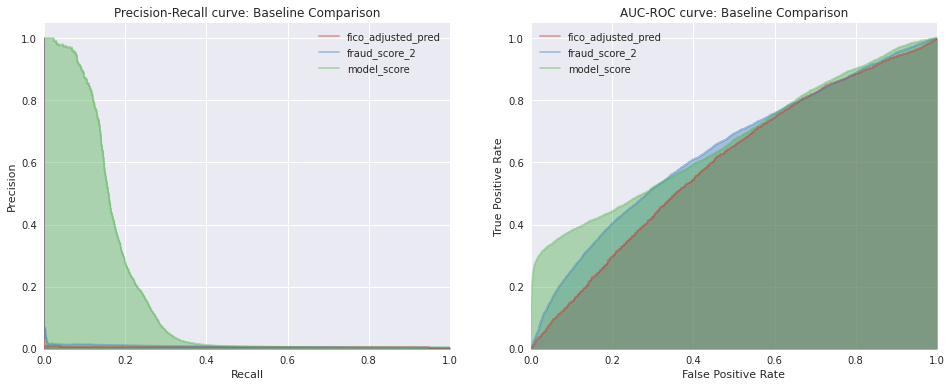

In [14]:
# get all the snapshots
for dt_str in tqdm(monitoring_dates):
    for mname, model in models.items(): 

        dt = pd.to_datetime(dt_str)

        # set folder:
        mntr_path = os.path.join(artifact_path, "monitoring", f"{mname}_{dt_str}_full")        
        os.makedirs(mntr_path, exist_ok=True)

        # get data on that date
        df_ = df[df.is_static 
                 & (df.sample_date == dt)]
        print(dt_str, df_.shape)

        # see data imbalance
        print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])

        # should have been processed when loaded, if not uncomment
        df_ = mu.prep_customer_data(df_)

        # make model pred and score
        df_["model_pred"] = model.predict_proba(df_[model.feature_name_])[:,1]
        df_["model_score"] = mu.scale_scores(df_["model_pred"])

        # insert into records
        test_dfs[dt_str] = df_
        pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
        report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)

        # store report in monitoring
        report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

        # model prediction
        mntr.get_segmented_performances(
            {dt_str: df_},
            "target",
            ["model_score"],
            mntr_path,
            model_name="customer_risk",
        )

        # on vs fico adjusted - only valid fico
        mntr.get_model_vs_baseline(
            df_[df_.fico_score.between(300,850)],
            "target",
            "model_score",
            "fico_adjusted_pred",
            mntr_path,
        )

        # auc/pr plots - on valid fico and sigma
        plot_df = df_.copy()
        plot_df = plot_df[
            ~plot_df[pred_cols].isna().any(axis=1) 
            & plot_df["fico_score"].between(300, 850)
        ]
        mntr.save_valid_performance_plots(
            {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
        )